# Lab 7: Decision Trees, Random Forests

## Problem 7

In [1]:
library(randomForest)
library(MASS)
attach(Boston)
set.seed(1)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [2]:
dim(Boston)
train=sample(1:dim(Boston)[1], dim(Boston)/2)
boston.test=Boston[-train, "medv"]

[1] 506  14

Let's create models varying the number of trees in our forest, in intervals of 25. We will do this 10 times.

In [3]:
for (j in c(1:10)) {
    MSE = vector()
    for (i in seq(25, 500, 25)) {
        model.boston = randomForest(medv~., data=Boston, subset=train, mtry=13, ntree = i)
        yhat = predict(model.boston, newdata=Boston[-train,])
        MSE=append(MSE,mean((yhat-boston.test)^2))
    }
    print(which.min(MSE) * 25)
}

[1] 75
[1] 75
[1] 75
[1] 100
[1] 50
[1] 125
[1] 125
[1] 100
[1] 100
[1] 25


It seems that there isn't much effect to varying the number of trees beyond 25. I get around the same MSE for each, so I get different models with the lowest MSE every time. (the above prints out the ```ntree``` value with the lowest MSE). But what if we varied ```mtry```?

In [4]:
freq = vector()
for (j in c(1:100)) {
    MSE = vector()
    for (i in c(6:13)) {
        model.boston = randomForest(medv~., data=Boston, subset=train, mtry=i, ntree = 125)
        yhat = predict(model.boston, newdata=Boston[-train,])
        MSE=append(MSE,mean((yhat-boston.test)^2))
    }
    freq = append(freq, (which.min(MSE) + 5))
}

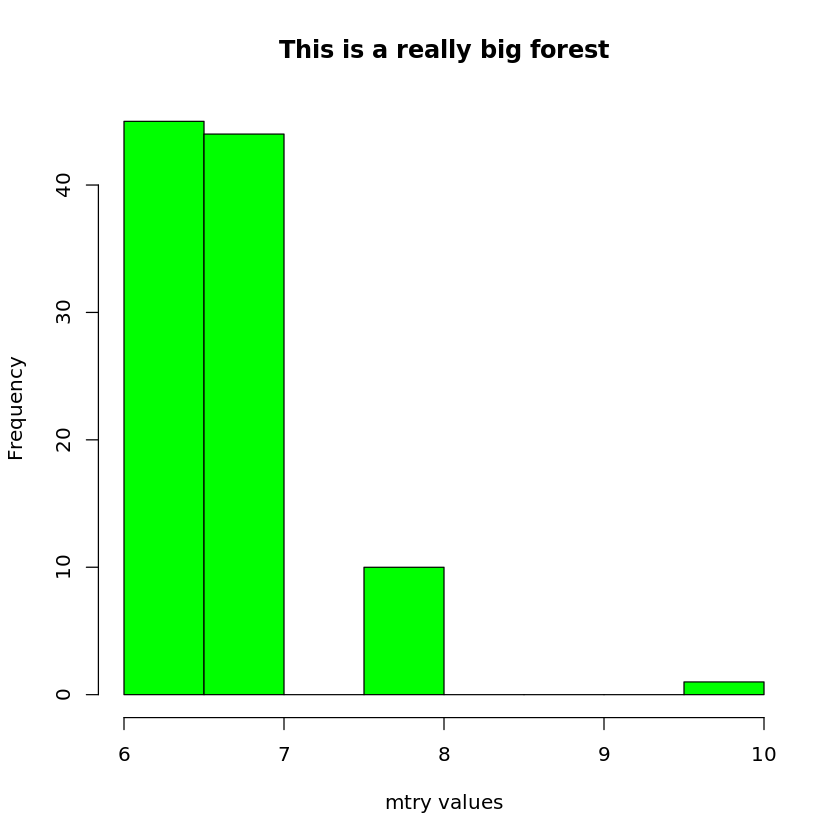

In [5]:
hist(freq, xlab="mtry values", ylab="Frequency", main="This is a really big forest", col="GREEN")

We ran forests using ```mtry``` = 6, 7, ..., 13 100 times. I appended minimum into a frequency vector. This histogram describes how many times each index was the minimum within the 6, 7,..., 13 forests. As we can see, using ```mtry``` = 6 is probably the best choice for this data.

## Problem 8

In [6]:
library(tree)
library(ISLR)
attach(Carseats)

In [7]:
names(Carseats)

[1] "Sales"       "CompPrice"   "Income"      "Advertising" "Population" 
 [6] "Price"       "ShelveLoc"   "Age"         "Education"   "Urban"      
[11] "US"

We want to predict sales as a function of the other variables using decision trees.

In [8]:
#a.)
dim(Carseats)
train=sample(1:dim(Carseats)[1], dim(Carseats)/2)
carseats.test=Carseats[-train, "Sales"]
Carseats[1:5,]

[1] 400  11

Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
11.22,111,48,16,260,83,Good,65,10,Yes,Yes
10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4.15,141,64,3,340,128,Bad,38,13,Yes,No


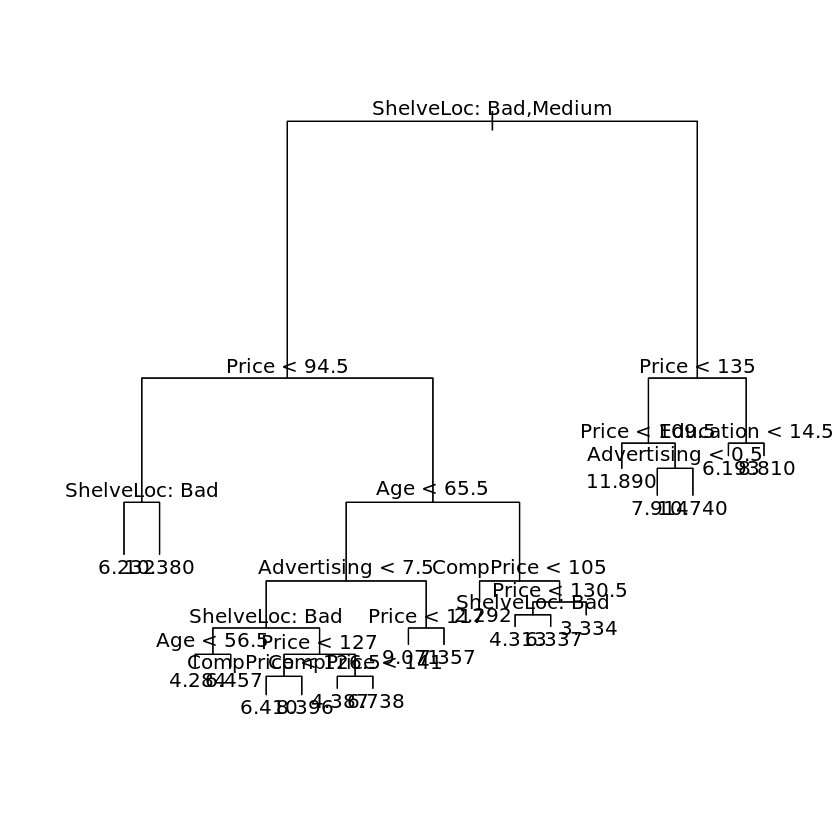

In [9]:
tree.carseats = tree(Sales~., data=Carseats, subset=train)
plot(tree.carseats)
text(tree.carseats, pretty=0)

By using the tree above, we can determine a rough estimate for what my Sales are going to be.

In [10]:
yhat = predict(tree.carseats, newdata=Carseats[-train,])
carseats.test=Carseats[-train, "Sales"]
mean((yhat-carseats.test)^2)

[1] 4.053499

We found that the test MSE is 5.103.

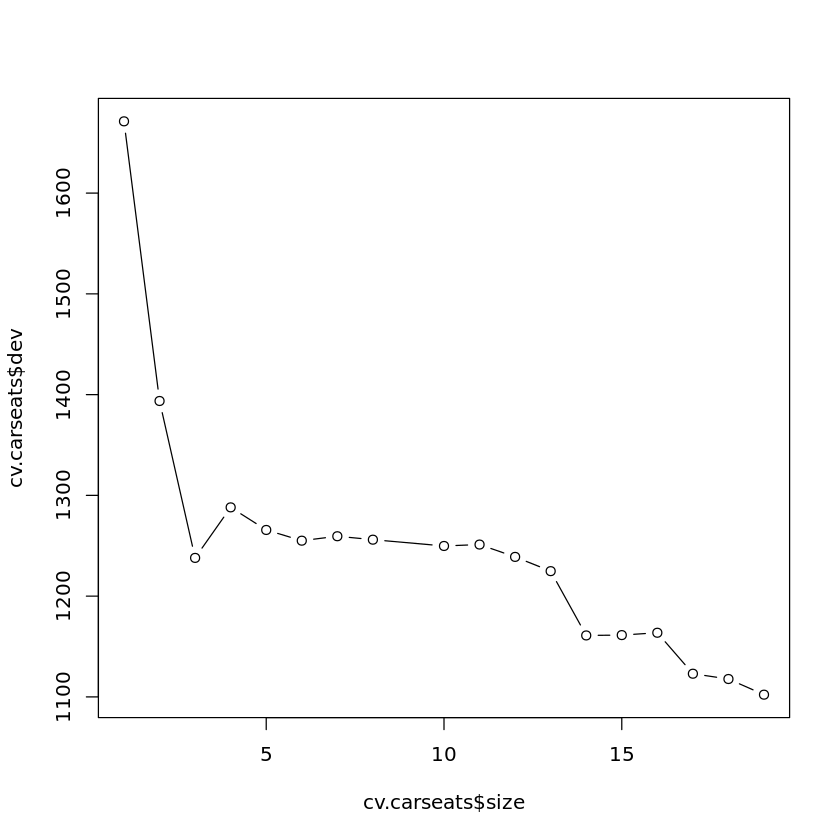

In [11]:
set.seed(2)
cv.carseats = cv.tree(tree.carseats)
plot(cv.carseats$size, cv.carseats$dev, type='b')

In [12]:
cv.carseats$size[which.min(cv.carseats$dev)]

[1] 19

We can see that the minimum of the deviance is at a tree with size 11. Knowing this, we can check what the MSE is going to be for a tree of that size.

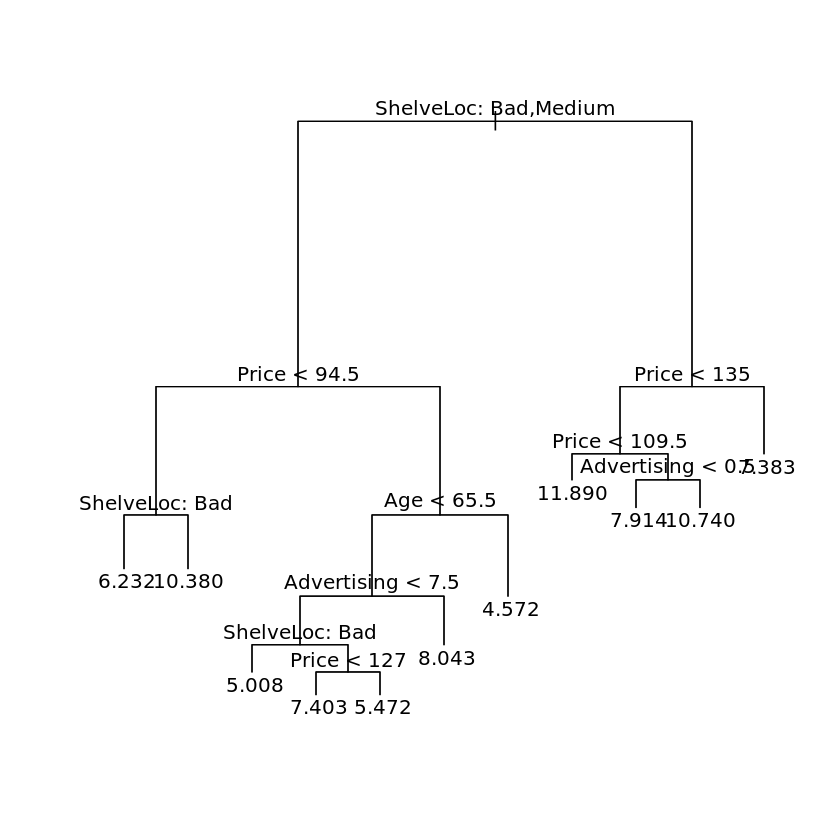

In [13]:
prune.carseats=prune.tree(tree.carseats, best=11)
plot(prune.carseats)
text(prune.carseats, pretty=0)

In [14]:
yhat = predict(prune.carseats, newdata=Carseats[-train,])
carseats.test=Carseats[-train, "Sales"]
mean((yhat-carseats.test)^2)

[1] 4.603772

Surprisingly, plotting the optimal level of tree complexity did NOT lower the testing MSE. I'm not too sure as to why this is the case however.

Let's try using bagging.

In [15]:
dim(Carseats)

[1] 400  11

In [16]:
library(randomForest)
set.seed(1)
bag.carseats = randomForest(Sales~.,data=Carseats, subset=train, mtry=10, importance=TRUE)
bag.carseats


Call:
 randomForest(formula = Sales ~ ., data = Carseats, mtry = 10,      importance = TRUE, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 2.977709
                    % Var explained: 64.24

[1] 2.644806

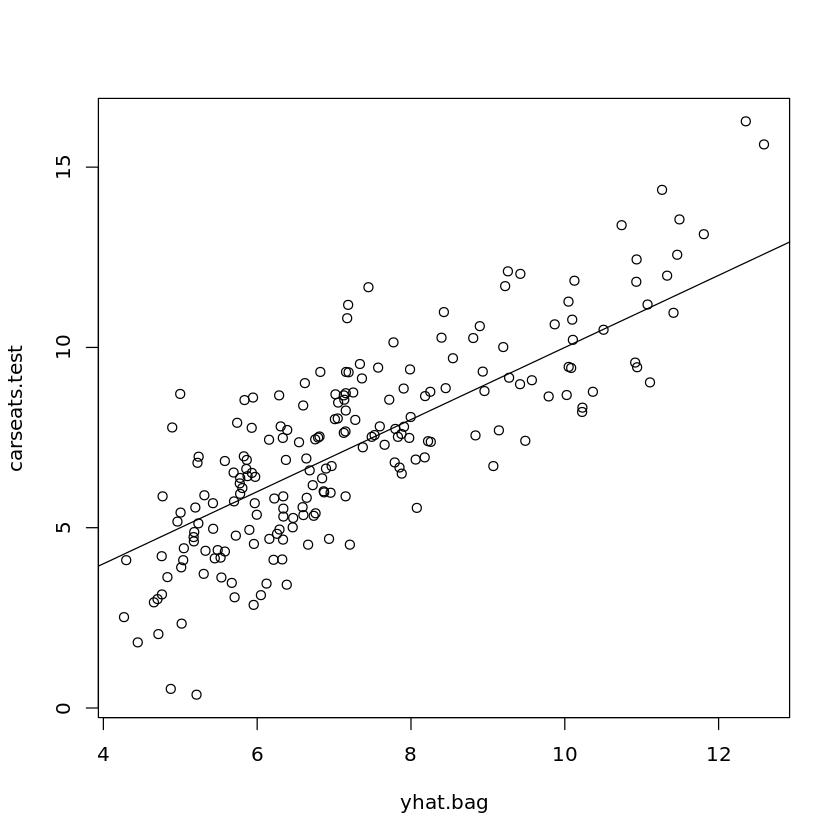

In [17]:
yhat.bag=predict(bag.carseats, newdata=Carseats[-train,])
plot(yhat.bag, carseats.test)
abline(0,1)
mean((yhat.bag-carseats.test)^2)

In [18]:
importance(bag.carseats)

,%IncMSE,IncNodePurity
CompPrice,17.1986770,135.250391
Income,4.5286961,86.489546
Advertising,16.3110770,104.920593
Population,-0.0075717,71.702896
Price,48.2655777,433.248465
ShelveLoc,53.7847609,500.002467
Age,18.9273973,203.582678
Education,4.5443884,55.077578
Urban,-3.1860752,7.467469
US,4.8870890,17.738792


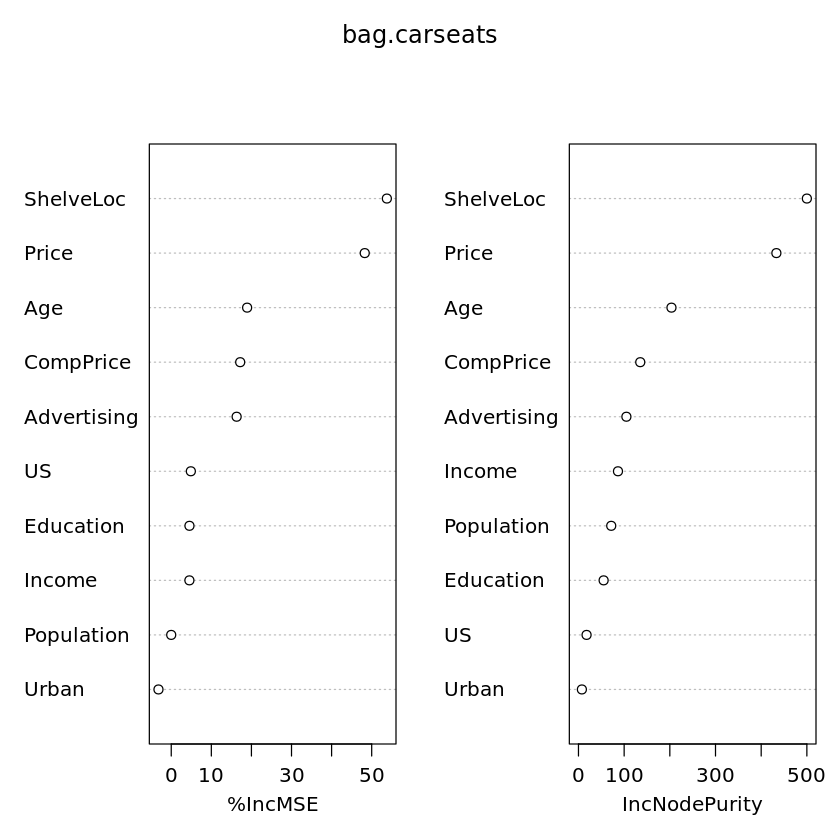

In [19]:
varImpPlot(bag.carseats)

Using the bag lowered the MSE by a lot! We can also see that by using ```importance()```, the ShelveLoc and Price are the best predictors of Sales in the dataset.

In [20]:
MSE = vector()
for (i in 3:10) {
    rf.carseats = randomForest(Sales~.,data=Carseats, subset=train, mtry=i, ntree=500)
    yhat.rf = predict(rf.carseats, newdata=Carseats[-train,])
    MSE = append(MSE, mean((yhat.rf-carseats.test)^2))
}

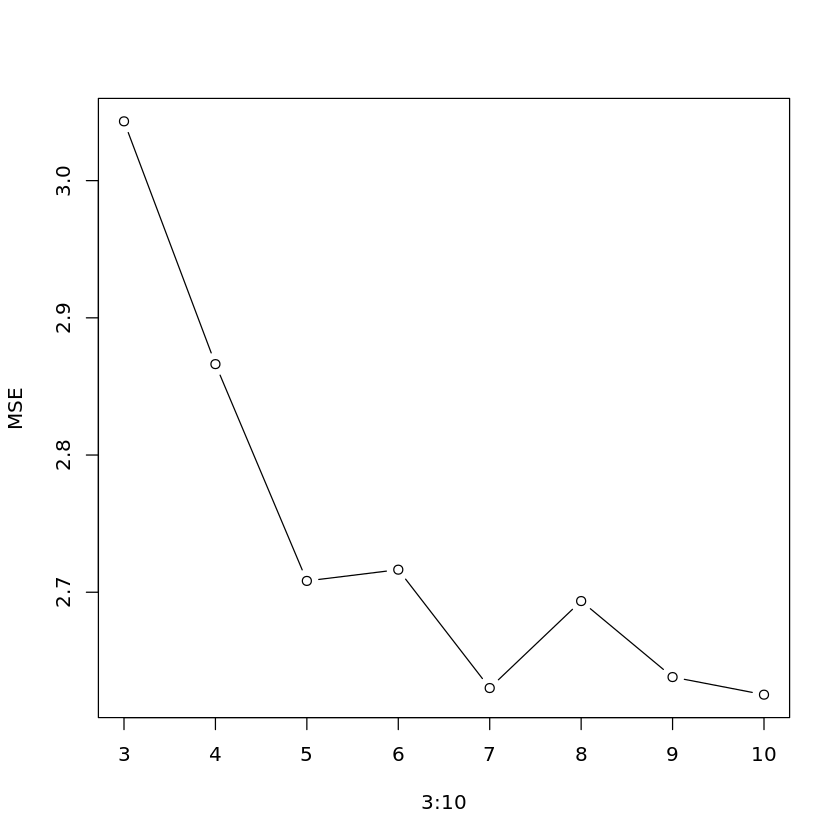

In [21]:
plot(3:10, MSE,type='b')

The effect of varying mtry on training the random forest is shown above. It makes a cool looking W. :D (dips down and then seems to go back up when overfitting past x = 8).

In [22]:
rf.carseats = randomForest(Sales~.,data=Carseats, subset=train, mtry=8, ntree=500)
yhat.rf = predict(rf.carseats, newdata=Carseats[-train,])
mean((yhat.rf-carseats.test)^2)

[1] 2.646132

,IncNodePurity
CompPrice,141.16675
Income,88.24973
Advertising,120.47106
Population,73.58841
Price,422.94733
ShelveLoc,492.49826
Age,210.05022
Education,55.70795
Urban,9.19547
US,18.69311


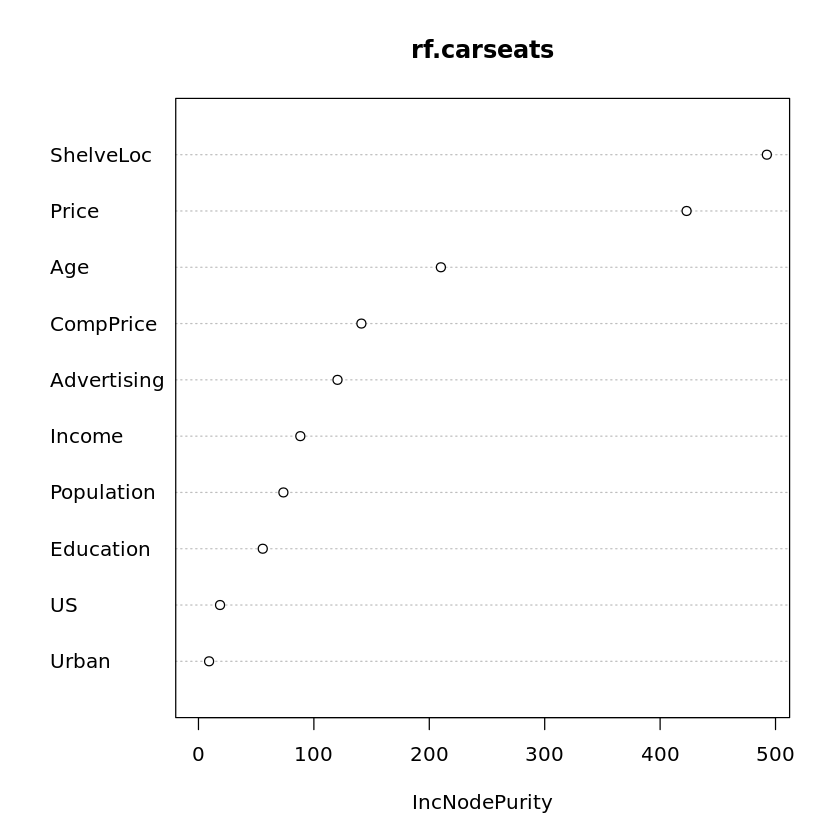

In [23]:
importance(rf.carseats)
varImpPlot(rf.carseats)

We still have ShelveLoc and Price as the most improtant factors, but it seems to be more polarized this time, i.e. the model is more sure that those two are the most important.